In [22]:
import os
import pickle
import shutil
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
base_path = '../'
use_merged_dataset = False
generate_all_datset_annots = False
imgsz = 512
base_data_dir = 'dataset1_files' if not generate_all_datset_annots else 'all_dataset_files'
base_data_name = 'all_dataset1' if not generate_all_datset_annots else 'all_dataset'
train_modes = ['train', 'validation']
folds = [0,1,2,3,4]
# annot_dirs_to_convert = [f'{base_path}/dataset1_files/all_dataset1_annotations_merged_train_0', f'{base_path}/dataset1_files/all_dataset1_annotations_merged_validation_0']

In [3]:
for fold in folds:
  for train_mode in train_modes:
    yolo_output_dir = f'{base_path}/{base_data_dir}/yolo_dataset1_{train_mode}_{fold}'
    if os.path.exists(yolo_output_dir):
      shutil.rmtree(yolo_output_dir)
    os.mkdir(yolo_output_dir)
    os.mkdir(f'{yolo_output_dir}/images')
    os.mkdir(f'{yolo_output_dir}/labels')

In [4]:
def get_valid_annots(annots):
    valid_annots = []
    for annot in annots:
        if len(annot['segmentation'][0]) >= 6:
            valid_annots.append(annot)
        else:
            print('Found invalid annot!!!')
    return valid_annots

In [5]:
for fold in folds:
  for train_mode in train_modes:
    yolo_output_dir = f'{base_path}/{base_data_dir}/yolo_dataset1_{train_mode}_{fold}'
    cur_img_dir = f'{base_path}/{base_data_dir}/{base_data_name}_imgs_merged_{train_mode}_{fold}' if use_merged_dataset else f'{base_path}/{base_data_dir}/{base_data_name}_imgs_{train_mode}_{fold}'
    cur_annots_dir = f'{base_path}/{base_data_dir}/{base_data_name}_annotations_merged_{train_mode}_{fold}' if use_merged_dataset else f'{base_path}/{base_data_dir}/{base_data_name}_annotations_{train_mode}_{fold}'
    for img in os.listdir(cur_img_dir):
      img_id = img.split('.png')[0]
      img_annot_file = f'{cur_annots_dir}/{img_id}.pkl'
      with open(img_annot_file, 'rb') as f:
        cur_annots = pickle.load(f)
      cur_annots = get_valid_annots(cur_annots)
      shutil.copy(f'{cur_img_dir}/{img}', f'{yolo_output_dir}/images/{img}')
      fp = open(f'{yolo_output_dir}/labels/{img_id}.txt', 'a')
      for cur_annot in cur_annots:
        top_left_x, top_left_y, width, height = cur_annot['bbox']
        cur_seg_relative = [float(coord)/imgsz for coord in cur_annot['segmentation'][0]]
        cur_seg_str = ' '.join([str(coord) for coord in cur_seg_relative])
        yolo_annot_line = f"{cur_annot['category_id']} {cur_seg_str}"
        fp.write(f'{yolo_annot_line}\n')
      fp.close()

In [23]:
import math
def load_img(img_dir, img_id):
  img = cv2.imread(f"{img_dir}/{img_id}.png")
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img

def add_border(image, border_size, border_color):
    height, width = image.shape[:2]
    new_height = height + 2 * border_size
    new_width = width + 2 * border_size
    bordered_image = np.zeros((new_height, new_width, 3), dtype=np.uint8)
    bordered_image[border_size:height + border_size, border_size:width + border_size] = image
    cv2.rectangle(bordered_image, (0, 0), (new_width - 1, new_height - 1), border_color, border_size)
    return bordered_image

def create_coco_annots(all_coords, pair_format=True):
  cur_tile_coco_annots = []
  for coords in all_coords:
#     print('======================')
#     print(coords)
#     print('======================')
    if not pair_format:
      coords = [[pt[0], pt[1]] for pt in zip(coords[::2], coords[1::2])]
    segmentations = [[pt for pair in coords for pt in pair]]
    segmentation_area = calculate_area(coords)
    min_x = min(coords, key=lambda x: x[0])[0]
    max_x = max(coords, key=lambda x: x[0])[0]
    min_y = min(coords, key=lambda x: x[1])[1]
    max_y = max(coords, key=lambda x: x[1])[1]
    segmentation_bbox = [min_x, min_y, max_x-min_x, max_y-min_y]
    category_id = 0
    cur_tile_coco_annots.append({
      'segmentation': segmentations,
      'area': segmentation_area,
      'bbox': segmentation_bbox,
      'category_id': category_id
    })
  return cur_tile_coco_annots

def get_annotated_img(imgs_dir, annots_dir, base_img_id):
  eps = 1
  annotated_image_coco = load_img(imgs_dir, base_img_id)
  img_height, img_width, _ = annotated_image_coco.shape
  tgt_annots = []
  with open(f'{annots_dir}/{base_img_id}.txt', 'r') as f:
    cur_annot_lines = [x.split(' ') for x in f.readlines()]
  for l in cur_annot_lines:
    tgt_annots.append([int(float(x)*512) for x in l[1:]])
    
  for tgt_annot in tgt_annots:
    coords = [[x, y] for x, y in zip(tgt_annot[::2], tgt_annot[1::2])]
    cv2.fillPoly(annotated_image_coco, pts=[np.array(coords)], color=(0,255,0))
    min_x = min(coords, key=lambda x: x[0])[0]
    min_y = min(coords, key=lambda x: x[1])[1]
    max_x = max(coords, key=lambda x: x[0])[0]
    max_y = max(coords, key=lambda x: x[1])[1]
    top_left = (min_x, min_y)
    bottom_right = (max_x, max_y)
#     if min_x <= eps or max_x >= img_width-eps or min_y <= eps or max_y >= img_height-eps:
#       annotated_image_coco = cv2.rectangle(annotated_image_coco, top_left, bottom_right, (255,0,0), 2)
    annotated_image_coco = cv2.rectangle(annotated_image_coco, top_left, bottom_right, (255,0,0), 2)
  annotated_image_coco = add_border(annotated_image_coco, 5, (0,0,255))
  return annotated_image_coco

img id is: e6d9bd78b840


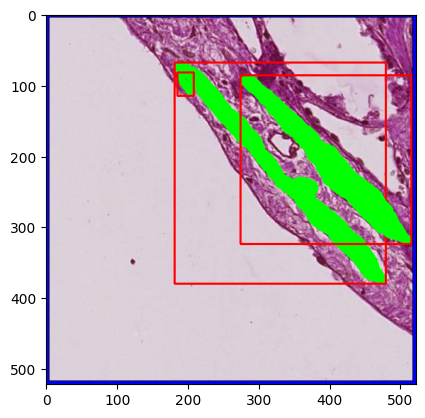

img id is: a3ebac2db19d


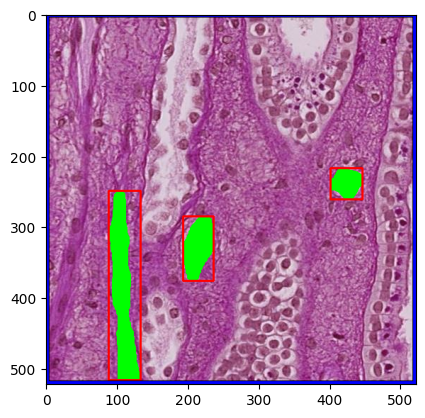

img id is: 3b83d7668181


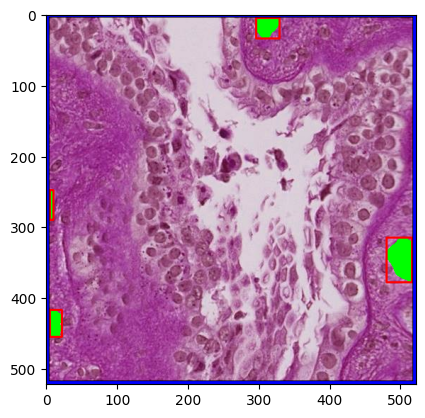

img id is: 103906a73e6d


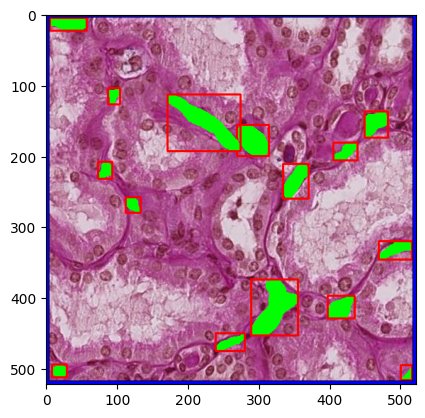

img id is: f45a29109ff5


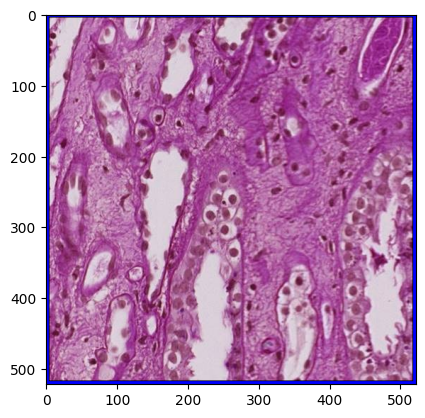

img id is: 65a235166914


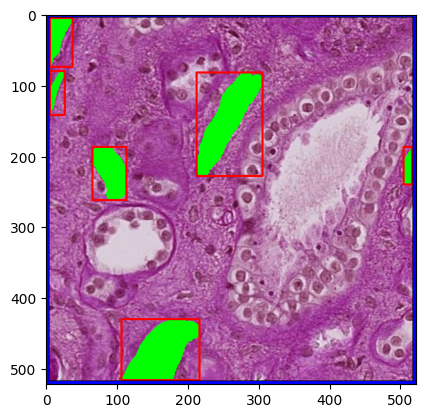

img id is: ce27b0613895


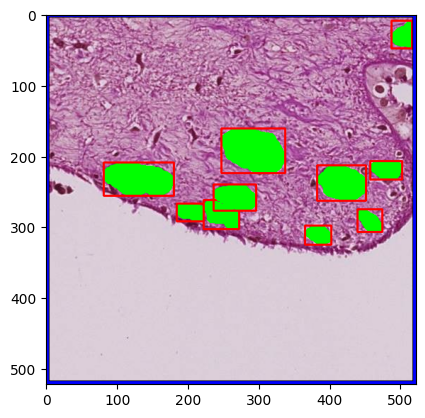

img id is: c9d0ac176add


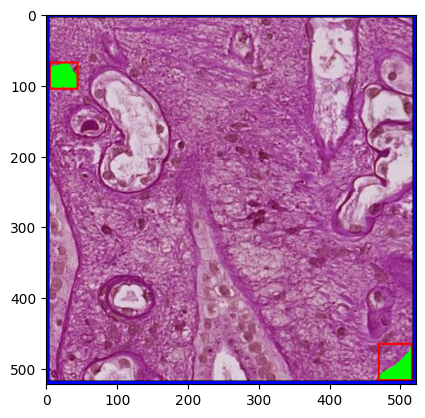

img id is: 0033bbc76b6b


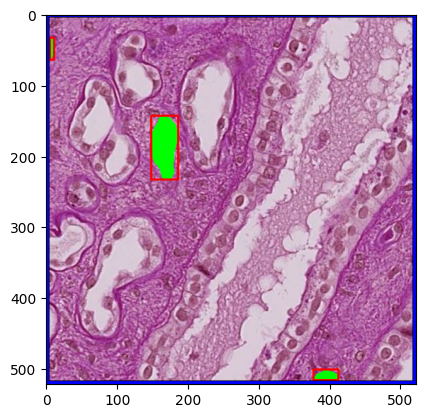

img id is: 2fd7649afbc1


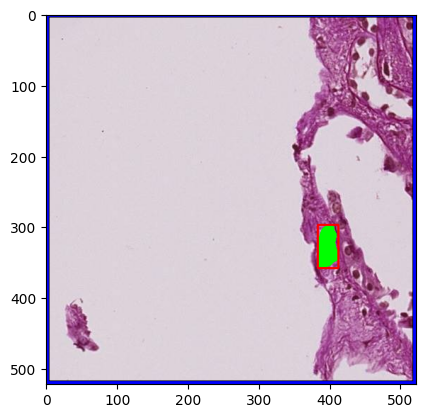

In [28]:
train_mode = 'train'
fold = 0
yolo_output_dir = f'{base_path}/{base_data_dir}/yolo_dataset1_{train_mode}_{fold}'
yolo_imgs_dir = f'{yolo_output_dir}/images'
yolo_annots_dir = f'{yolo_output_dir}/labels'

for yolo_annot_file in os.listdir(yolo_annots_dir)[58:68]:
    img_id = yolo_annot_file.split('.')[0]
    print(f'img id is: {img_id}')
    img = get_annotated_img(yolo_imgs_dir, yolo_annots_dir, img_id)
    plt.imshow(img)
    plt.show()
        
    

In [ ]:
def check_duplicate_labels(coords1, coords2):
    coords1 = [float(coord.replace('\n', '')) for coord in coords1]
    coords2 = [float(coord.replace('\n', '')) for coord in coords2]
    return all([x==y for x,y in zip(coords1, coords2)])

In [ ]:
for fold in folds:
  for train_mode in train_modes:
    yolo_annot_dir = f'{base_path}/{base_data_dir}/yolo_dataset1_{train_mode}_{fold}/labels'
    yolo_annot_files = os.listdir(yolo_annot_dir)
    for yolo_annot_file in yolo_annot_files:
        with open(f'{yolo_annot_dir}/{yolo_annot_file}', 'r') as f:
            full_annot_data = f.readlines()
        all_coords = [line.split(' ') for line in full_annot_data]
        for i in range(len(all_coords)):
            for j in range(i+1, len(all_coords)):
                if check_duplicate_labels(all_coords[i], all_coords[j]):
                    print(f'Found duplicate coords in file {yolo_annot_file}')

In [ ]:
custom_config = """lr0: 0.01  # initial learning rate (SGD=1E-2, Adam=1E-3)
lrf: 0.1  # final OneCycleLR learning rate (lr0 * lrf)
momentum: 0.937  # SGD momentum/Adam beta1
weight_decay: 0.0005  # optimizer weight decay 5e-4
warmup_epochs: 3.0  # warmup epochs (fractions ok)
warmup_momentum: 0.8  # warmup initial momentum
warmup_bias_lr: 0.1  # warmup initial bias lr
box: 0.05  # box loss gain
cls: 0.3  # cls loss gain
cls_pw: 1.0  # cls BCELoss positive_weight
obj: 0.7  # obj loss gain (scale with pixels)
obj_pw: 1.0  # obj BCELoss positive_weight
iou_t: 0.20  # IoU training threshold
anchor_t: 4.0  # anchor-multiple threshold
# anchors: 3  # anchors per output layer (0 to ignore)
fl_gamma: 0.0  # focal loss gamma (efficientDet default gamma=1.5)
hsv_h: 0.015  # image HSV-Hue augmentation (fraction)
hsv_s: 0.7  # image HSV-Saturation augmentation (fraction)
hsv_v: 0.4  # image HSV-Value augmentation (fraction)
degrees: 0.0  # image rotation (+/- deg)
translate: 0.1  # image translation (+/- fraction)
scale: 0.9  # image scale (+/- gain)
shear: 0.0  # image shear (+/- deg)
perspective: 0.0  # image perspective (+/- fraction), range 0-0.001
flipud: 0.0  # image flip up-down (probability)
fliplr: 0.5  # image flip left-right (probability)
mosaic: 1.0  # image mosaic (probability)
mixup: 0.1  # image mixup (probability)
copy_paste: 0.1  # segment copy-paste (probability)"""

In [ ]:
custom_config_lines = custom_config.split('\n')
custom_dict = {custom_config_line.split()[0][:-1]: custom_config_line.split()[1] for custom_config_line in custom_config_lines }
custom_dict